In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Importance Sampling

$$
\text{To approximate an expectation, we evaluate:}
$$

$$
\mathbb{E}[f] = \int f(z) p(z) \, dz
$$

$$
\text{Using importance sampling, we rewrite:}
$$

$$
\mathbb{E}[f] = \int f(z) \frac{p(z)}{q(z)} q(z) \, dz
$$

$$
\text{where } q(z) \text{ is a proposal distribution from which it is easy to sample. Samples } z^{(l)} \text{ are drawn from } q(z), \text{ giving:}
$$

$$
\mathbb{E}[f] \approx \frac{1}{L} \sum_{l=1}^{L} w_l f(z^{(l)})
$$

$$
\text{with weights:}
$$

$$
w_l = \frac{p(z^{(l)})}{q(z^{(l)})}.
$$

### Unnormalized Distributions
$$
\text{If } p(z) \text{ and } q(z) \text{ are unnormalized, }
p(z) = \frac{\tilde{p}(z)}{Z_p}, \, q(z) = \frac{\tilde{q}(z)}{Z_q}, \text{ then:}
$$

$$
w_l = \frac{\tilde{p}(z^{(l)})}{\tilde{q}(z^{(l)})}.
$$

$$
\text{The normalization constants can be estimated as:}
$$

$$
\frac{Z_p}{Z_q} \approx \frac{1}{L} \sum_{l=1}^{L} w_l.
$$

### Normalized Weights
$$
\text{To improve numerical stability, normalized weights are used:}
$$

$$
\tilde{w}_l = \frac{w_l}{\sum_{m=1}^{L} w_m}.
$$

$$
\text{The expectation becomes:}
$$

$$
\mathbb{E}[f] \approx \sum_{l=1}^{L} \tilde{w}_l f(z^{(l)}).
$$

---

## Key Considerations

1. **Importance Sampling Quality**:
   - The proposal distribution $ q(z) $ should closely match $ p(z) $ to minimize variance.
   - Poor matching leads to high variance, dominated by a few large weights.

2. **Effective Sample Size**:
   - The effective sample size measures the diversity of importance weights:
    $$
     N_{\text{eff}} = \frac{1}{\sum_{l=1}^{L} \tilde{w}_l^2}.
     $$

3. **High Dimensionality Challenges**:
   - In high dimensions, $ q(z) $ must not be negligible where $ p(z) $ is significant.
   - Small or zero values in $ q(z) $ where $ p(z) $ is large can lead to biased or arbitrarily wrong results.

---


In [2]:
import random
import math

def importance_sampling(target_density, proposal_density, proposal_sampler, num_samples, f=lambda z: 1):
    """
    Importance sampling algorithm without using numpy.

    Args:
        target_density: Function to evaluate the target density p(z).
        proposal_density: Function to evaluate the proposal density q(z).
        proposal_sampler: Function to draw samples from the proposal distribution.
        num_samples: Number of samples to draw.
        f: Function for which the expectation is computed.

    Returns:
        Estimated expectation, normalized weights, and samples.
    """
    samples = [proposal_sampler() for _ in range(num_samples)]
    weights = [target_density(z) / proposal_density(z) for z in samples]
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]

    # Compute the weighted expectation
    expectation = sum(w * f(z) for w, z in zip(normalized_weights, samples))
    return expectation, normalized_weights, samples

# Example Usage
# Define target and proposal distributions
def target_density(z):
    """Standard normal distribution p(z)."""
    return math.exp(-z**2 / 2) / math.sqrt(2 * math.pi)

def proposal_density(z):
    """Laplace distribution q(z)."""
    return math.exp(-abs(z)) / 2

def proposal_sampler():
    """Sample from Laplace distribution using inverse transform sampling."""
    u = random.uniform(-0.5, 0.5)  # Uniform distribution in the range [-0.5, 0.5]
    return -math.log(1 - 2 * abs(u)) * (1 if u > 0 else -1)  # Generate Laplace sample

# Compute expectation
num_samples = 1000
f = lambda z: z**2  # Example function
expectation, normalized_weights, samples = importance_sampling(
    target_density, proposal_density, proposal_sampler, num_samples, f
)

print("Estimated expectation:", expectation)


Estimated expectation: 1.0265152058614675


##  Sampling-Importance-Resampling

The rejection sampling method discussed in Section 11.1.2 depends in part for its success on the determination of a suitable value for the constant $ k $. For many pairs of distributions $ p(z) $ and $ q(z) $, it will be impractical to determine a suitable value for $ k $ in that any value that is sufficiently large to guarantee a bound on the desired distribution will lead to impractically small acceptance rates. 

As in the case of rejection sampling, the sampling-importance-resampling (SIR) approach also makes use of a sampling distribution $ q(z) $ but avoids having to determine the constant $ k $. There are two stages to the scheme. 

### First Stage:
In the first stage, $ L $ samples $ z^{(1)}, \dots, z^{(L)} $ are drawn from $ q(z) $.

### Second Stage:
In the second stage, weights $ w_1, \dots, w_L $ are constructed using the formula:

$$
w_l = \frac{p(z^{(l)})}{q(z^{(l)})} \quad \text{for} \quad l = 1, 2, \dots, L.
$$

Finally, a second set of $ L $ samples is drawn from the discrete distribution $ (z^{(1)}, \dots, z^{(L)}) $ with probabilities given by the weights $ (w_1, \dots, w_L) $.

### Approximation of the Distribution
The resulting $ L $ samples are only approximately distributed according to $ p(z) $, but the distribution becomes correct in the limit $ L \to \infty $. To see this, consider the univariate case, and note that the cumulative distribution of the resampled values is given by:

$$
P(z \leq a) = \sum_{l: z^{(l)} \leq a} w_l = \sum_{l} \frac{p(z^{(l)})}{q(z^{(l)})} I(z^{(l)} \leq a),
$$

where $ I(\cdot) $ is the indicator function, which equals 1 if its argument is true and 0 otherwise. Taking the limit $ L \to \infty $, and assuming suitable regularity of the distributions, we can replace the sums by integrals weighted according to the original sampling distribution $ q(z) $:

$$
P(z \leq a) = \int_{-\infty}^{a} \frac{p(z)}{q(z)} q(z) \, dz = \int_{-\infty}^{a} p(z) \, dz,
$$

which is the cumulative distribution function of $ p(z) $.

### Evaluation of Moments
For a finite value of $ L $, and a given initial sample set, the resampled values will only approximately be drawn from the desired distribution. As with rejection sampling, the approximation improves as the sampling distribution $ q(z) $ gets closer to the desired distribution $ p(z) $. 

When $ q(z) = p(z) $, the initial samples $ (z^{(1)}, \dots, z^{(L)}) $ have the desired distribution, and the weights $ w_n = \frac{1}{L} $, so that the resampled values also have the desired distribution. 

If moments with respect to the distribution $ p(z) $ are required, they can be evaluated directly using the original samples together with the weights:

$$
E[f(z)] = \int f(z) p(z) \, dz = \sum_{l=1}^{L} w_l f(z^{(l)}),
$$

where

$$
w_l = \frac{p(z^{(l)})}{q(z^{(l)})}.
$$


In [ ]:
import numpy as np
import random

# Define the target and proposal distributions
def target_density(z):
    """Target distribution p(z)"""
    # Example: Standard Normal Distribution
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)

def proposal_density(z):
    """Proposal distribution q(z)"""
    # Example: Laplace Distribution
    return 0.5 * np.exp(-np.abs(z))

def proposal_sampler():
    """Sampling from the proposal distribution (Laplace)"""
    u = random.uniform(-1, 1)
    return -np.log(1 - 2 * abs(u)) if u > 0 else np.log(1 - 2 * abs(u))

# Sampling-Importance-Resampling (SIR) method
def sampling_importance_resampling(target_density, proposal_density, proposal_sampler, num_samples):
    # First stage: draw samples from proposal distribution q(z)
    samples = [proposal_sampler() for _ in range(num_samples)]
    
    # Second stage: calculate importance weights
    weights = [target_density(z) / proposal_density(z) for z in samples]
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    
    # Resample according to the weights
    resampled_samples = np.random.choice(samples, size=num_samples, p=normalized_weights)
    
    return resampled_samples, normalized_weights, samples

# Example usage
num_samples = 1000
resampled_samples, normalized_weights, original_samples = sampling_importance_resampling(
    target_density, proposal_density, proposal_sampler, num_samples
)

# Print a few resampled samples and their weights
print("Resampled samples:", resampled_samples[:10])
print("Normalized weights:", normalized_weights[:10])


In [ ]:
import random
import math
import plotly.graph_objects as go

# Define the target and proposal distributions
def target_density(z):
    """Target distribution p(z)"""
    # Example: Standard Normal Distribution
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * z**2)

def proposal_density(z):
    """Proposal distribution q(z)"""
    # Example: Laplace Distribution
    return 0.5 * math.exp(-abs(z))

def proposal_sampler():
    """Sampling from the proposal distribution (Laplace)"""
    u = random.uniform(-1, 1)
    return -math.log(1 - 2 * abs(u)) if u > 0 else math.log(1 - 2 * abs(u))

# Sampling-Importance-Resampling (SIR) method
def sampling_importance_resampling(target_density, proposal_density, proposal_sampler, num_samples):
    # First stage: draw samples from proposal distribution q(z)
    samples = [proposal_sampler() for _ in range(num_samples)]
    
    # Second stage: calculate importance weights
    weights = [target_density(z) / proposal_density(z) for z in samples]
    
    # Normalize weights
    total_weight = sum(weights)
    normalized_weights = [w / total_weight for w in weights]
    
    # Resample according to the weights
    resampled_samples = random.choices(samples, weights=normalized_weights, k=num_samples)
    
    return resampled_samples, normalized_weights, samples

# Example usage
num_samples = 1000
resampled_samples, normalized_weights, original_samples = sampling_importance_resampling(
    target_density, proposal_density, proposal_sampler, num_samples
)

# Visualization using Plotly.js
# Original samples histogram
fig = go.Figure()

# Adding original samples
fig.add_trace(go.Histogram(
    x=original_samples,
    histnorm='probability density',
    name='Original Samples',
    opacity=0.6
))

# Adding resampled samples
fig.add_trace(go.Histogram(
    x=resampled_samples,
    histnorm='probability density',
    name='Resampled Samples',
    opacity=0.6
))

# Update layout
fig.update_layout(
    title='Sampling-Importance-Resampling (SIR)',
    xaxis_title='z',
    yaxis_title='Density',
    barmode='overlay'
)

fig.show()


##  Sampling and the EM Algorithm

In addition to providing a mechanism for direct implementation of the Bayesian framework, Monte Carlo methods can also play a role in the frequentist paradigm, for example to find maximum likelihood solutions. In particular, sampling methods can be used to approximate the E step of the EM algorithm for models in which the E step cannot be performed analytically.

Consider a model with hidden variables $ Z $, visible (observed) variables $ X $, and parameters $ \theta $. The function that is optimized with respect to $ \theta $ in the M step is the expected complete-data log-likelihood, given by:

$$
Q(\theta, \theta_{\text{old}}) = \int p(Z|X, \theta_{\text{old}}) \ln p(Z, X|\theta) \, dZ
$$

We can use sampling methods to approximate this integral by a finite sum over samples $ \{Z^{(l)}\} $, which are drawn from the current estimate for the posterior distribution $ p(Z|X, \theta_{\text{old}}) $, so that:

$$
Q(\theta, \theta_{\text{old}}) \approx \frac{1}{L} \sum_{l=1}^{L} \ln p(Z^{(l)}, X|\theta)
$$

The $ Q $-function is then optimized in the usual way in the M step. This procedure is called the **Monte Carlo EM algorithm**.

It is straightforward to extend this to the problem of finding the ## Data Augmentation Algorithm (IP Algorithm)

Now suppose we move from a maximum likelihood approach to a full Bayesian treatment in which we wish to sample from the posterior distribution over the parameter vector $ \theta $. In principle, we would like to draw samples from the joint posterior $ p(\theta, Z|X) $, but we shall suppose that this is computationally difficult. Suppose further that it is relatively straightforward to sample from the complete-data parameter posterior $ p(\theta|Z, X) $. 

This inspires the **data augmentation algorithm**, which alternates between two steps known as the **I-step** (imputation step, analogous to an E step) and the **P-step** (posterior step, analogous to an M step).

### IP Algorithm

#### I-step
We wish to sample from $ p(Z|X) $, but we cannot do this directly. Instead, we use the relation:

$$
p(Z|X) = \int p(Z|\theta, X)p(\theta|X) \, d\theta
$$

Thus, for $ l = 1, \dots, L $, we first draw a sample $ \theta^{(l)} $ from the current estimate for $ p(\theta|X) $, and then use this to draw a sample $ Z^{(l)} $ from $ p(Z|\theta^{(l)}, X) $.

#### P-step
Given the relation:

$$
p(\theta|X) = \int p(\theta|Z, X)p(Z|X) \, dZ
$$

We use the samples $ \{Z^{(l)}\} $ obtained from the I-step to compute a revised estimate of the posterior distribution over $ \theta $, given by:

$$
p(\theta|X) \approx \frac{1}{L} \sum_{l=1}^{L} p(\theta|Z^{(l)}, X)
$$

By assumption, it will be feasible to sample from this approximation in the I-step.

---

Note that we are making a (somewhat artificial) distinction between parameters $ \theta $ and hidden variables $ Z $. From now on, we blur this distinction and focus simply on the problem of drawing samples from a given posterior distribution.



In [5]:
import random
import math

# Define placeholder functions for the problem-specific distributions
def sample_theta_given_x():
    """
    Sample from the posterior distribution p(θ|X).
    This should be problem-specific.
    """
    # Example: Sampling from a uniform distribution as a placeholder
    return random.uniform(0, 1)

def sample_z_given_theta_and_x(theta):
    """
    Sample from the conditional distribution p(Z|θ, X).
    This should be problem-specific.
    """
    # Example: Sampling from a normal distribution centered at θ
    return random.gauss(theta, 1)

def posterior_theta_given_z_and_x(z):
    """
    Compute p(θ|Z, X).
    This is problem-specific and should return a function that represents the posterior.
    """
    # Example: Gaussian centered at Z with some fixed variance
    return lambda theta: math.exp(-0.5 * (theta - z)**2)

# IP Algorithm Implementation
def data_augmentation(num_samples):
    """
    Perform the IP Algorithm for data augmentation.

    Args:
        num_samples: Number of samples to draw.

    Returns:
        A list of samples for θ.
    """
    theta_samples = []
    z_samples = []

    for _ in range(num_samples):
        # I-step: Sample θ from p(θ|X)
        theta = sample_theta_given_x()

        # Sample Z from p(Z|θ, X)
        z = sample_z_given_theta_and_x(theta)

        # Store samples
        theta_samples.append(theta)
        z_samples.append(z)

    # P-step: Update p(θ|X) using the samples of Z
    updated_theta_distribution = []
    for z in z_samples:
        posterior = posterior_theta_given_z_and_x(z)
        # Example: Sampling one value of θ from the posterior for simplicity
        updated_theta = random.gauss(z, 1)  # Sampling a Gaussian with Z as mean
        updated_theta_distribution.append(updated_theta)

    return updated_theta_distribution, z_samples

# Run the algorithm
num_samples = 100
theta_samples, z_samples = data_augmentation(num_samples)

# Print the results
print("Theta Samples:")
print(theta_samples)
print("\nZ Samples:")
print(z_samples)


Theta Samples:
[2.0337835336687333, -2.011583643405241, -2.01778201229794, 1.6102145993810955, -1.1566752147173938, 0.027997709501515033, 2.7399863592492437, 2.3365601670805742, 4.4426769445724865, -0.26151251568049594, 2.6613491316200433, 1.1154833032611509, 1.481118026890365, 3.371916726139246, 0.31938723922606294, 2.5334559659973763, 1.3770083441312218, 0.8025288040161573, -0.7417341369550172, 0.4062728084179063, 3.033185716870035, -2.2262533285198858, 1.8375370351818345, -1.1693495920590682, 2.020471150321594, 0.7743078268319945, -1.231511895026669, 1.1071254019696684, 0.16490229205828044, 1.4758319293057554, 0.334225074420749, -1.3711680802576922, -1.173155191768008, 2.886323234409211, -0.8583411615669247, 2.1809866685431523, 0.32685549711170037, -0.4850736726332697, -0.4663396587406399, 2.4215009341579874, 1.6401087668430625, 0.0902225963590646, 1.7195320438135808, 0.0893573683290457, -0.006997322598361333, -0.9692437179381861, 0.7154646475787338, 0.9680059470149871, 0.9022509950

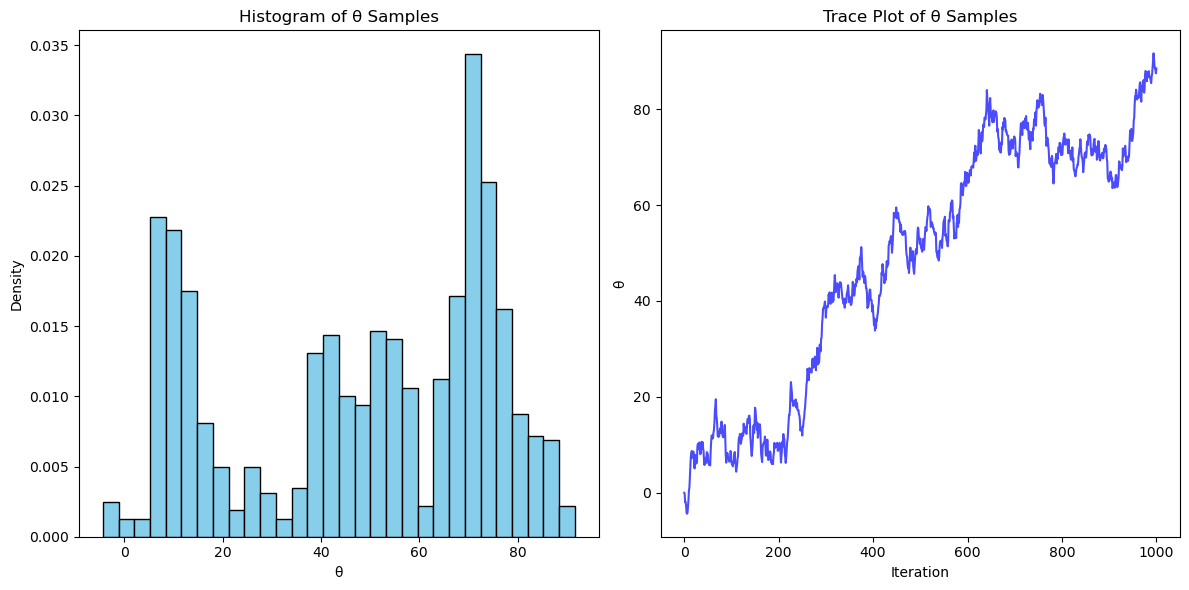

In [6]:
import random
import math
import matplotlib.pyplot as plt

def p_theta_given_zx(theta, z, x):
    """
    Placeholder for the conditional posterior p(θ|Z, X).
    Replace this with the actual model definition.
    """
    # Example: Gaussian likelihood with mean z and precision (variance) x
    mean = z
    variance = x
    return (1 / math.sqrt(2 * math.pi * variance)) * math.exp(-((theta - mean) ** 2) / (2 * variance))

def p_z_given_thetax(z, theta, x):
    """
    Placeholder for the conditional posterior p(Z|θ, X).
    Replace this with the actual model definition.
    """
    # Example: Gaussian likelihood with mean theta and precision (variance) x
    mean = theta
    variance = x
    return (1 / math.sqrt(2 * math.pi * variance)) * math.exp(-((z - mean) ** 2) / (2 * variance))

def sample_from_gaussian(mean, variance):
    """
    Draw a sample from a Gaussian distribution using the Box-Muller transform.
    """
    u1 = random.uniform(0, 1)
    u2 = random.uniform(0, 1)
    z = math.sqrt(-2 * math.log(u1)) * math.cos(2 * math.pi * u2)
    return mean + z * math.sqrt(variance)

def ip_algorithm(num_iterations, x, initial_theta):
    """
    Implements the IP Algorithm.

    Args:
    - num_iterations: Number of iterations to run the algorithm.
    - x: Observed data (fixed for the model).
    - initial_theta: Initial estimate of θ.

    Returns:
    - List of sampled θ values.
    """
    theta_samples = [initial_theta]

    for _ in range(num_iterations):
        # I-step: Sample Z from p(Z | θ, X)
        current_theta = theta_samples[-1]
        z_sample = sample_from_gaussian(current_theta, x)  # Example with Gaussian p(Z|θ, X)

        # P-step: Sample θ from p(θ | Z, X)
        theta_sample = sample_from_gaussian(z_sample, x)  # Example with Gaussian p(θ|Z, X)
        theta_samples.append(theta_sample)

    return theta_samples

# Example usage:
num_iterations = 1000
x = 1.0  # Fixed observed data (variance)
initial_theta = 0.0

samples = ip_algorithm(num_iterations, x, initial_theta)

# Plotting
plt.figure(figsize=(12, 6))

# Histogram of sampled θ values
plt.subplot(1, 2, 1)
plt.hist(samples, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title("Histogram of θ Samples")
plt.xlabel("θ")
plt.ylabel("Density")

# Trace plot of sampled θ values
plt.subplot(1, 2, 2)
plt.plot(samples, color='blue', alpha=0.7)
plt.title("Trace Plot of θ Samples")
plt.xlabel("Iteration")
plt.ylabel("θ")

plt.tight_layout()
plt.show()
